In [1]:
!pip install pymc3

Defaulting to user installation because normal site-packages is not writeable


### Imports:

In [3]:
%matplotlib inline
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano

plt.style.use('seaborn-darkgrid')

Modelo

In [4]:
def SIR(y, t, p):
    dt = (1 - y[0])*p[0]*p[1]*(y[0])**p[2] + y[0]*p[0]*(1-p[1])*(1-y[0])**p[2]
    return [dt]

Testando os dados do modelo:

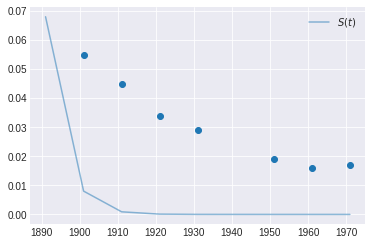

In [8]:
times = np.array([1891, 1901, 1911, 1921, 1931, 1951, 1961, 1971])


# Gerando curvas simuladas
y = odeint(SIR, y0=[0.068], t=times, args=((-0.22, 0.8, 1),), rtol=1e-8) # argumentos chutados
# dados (nesse caso ficticios)
yobs = np.array([[0.055], [0.045], [0.034], [0.029], [0.019], [0.016], [0.017]])

plt.plot(times[1::], yobs, marker='o', linestyle='none')
plt.plot(times, y[:], color='C0', alpha=0.5, label=f'$S(t)$')
plt.legend();

Definindo o modelo:

In [9]:
sir_model = DifferentialEquation(
    func=SIR,
    times=np.array([1901, 1911, 1921, 1931, 1951, 1961, 1971]),
    n_states=1,
    n_theta=3,
    t0=1891,
)

Estimação dos parametro (c, s e a):

In [ ]:
with pm.Model() as model4:
    sigma = pm.HalfCauchy('sigma', 1, shape=1)

    # Distribuições a priori (lower liminf, upper limsup)
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2, 3)
    c = pm.Uniform('c', -3, 0)
    s = pm.Uniform('s', 0, 1)
    a = pm.Uniform('a', 0, 20)
    
    sir_curves = sir_model(y0=[0.068], theta=[c, s, a])

    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sigma=sigma, observed=yobs)
#    db = pm.backends.HDF5('traces.h5') # Salva as amostras e assim evita de manter tudo na memória
    trace = pm.sample(2000, tune=1000, start={'R0': np.array(2), 'c': np.array(-0.2), 'sigma': np.array([1]), 's': np.array(0.5), 'a': np.array(1.31)})

/tmp/ipykernel_3798/1089066283.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, tune=1000, start={'R0': np.array(2), 'c': np.array(-0.2), 'sigma': np.array([1]), 's': np.array(0.5), 'a': np.array(1.31)})
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, s, c, R0, sigma]


Dados da estimação dos parametros:

In [ ]:
data = az.from_pymc3(trace=trace)
data

Posteriori dos parametros

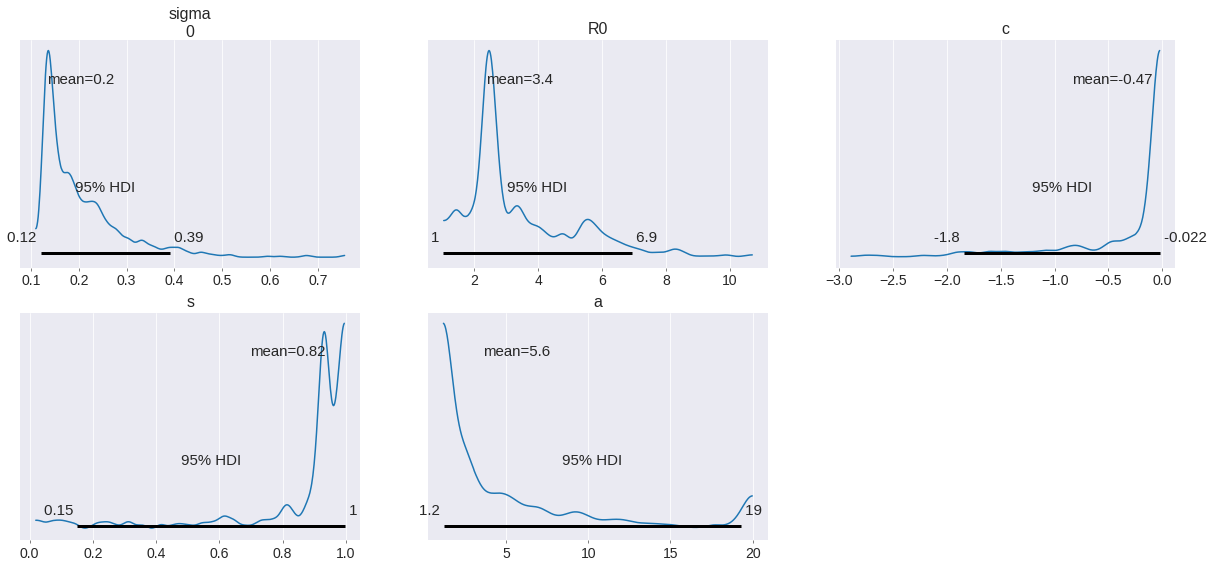

In [18]:
az.plot_posterior(data, round_to=2, hdi_prob=0.95);

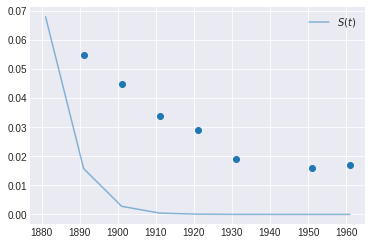

In [9]:
y = odeint(SIR, y0=[0.068], t=times, args=((-1.059, 0.8288, 5.812),), rtol=1e-8) # argumentos chutados

plt.plot(times[1::], yobs, marker='o', linestyle='none')
plt.plot(times, y[:], color='C0', alpha=0.5, label=f'$S(t)$')
plt.legend();